# Lab session 6

In and after this lab session you will

    - train a Gaussian NBC with the EM algorithm
    - compare the results you get to those of the k-Means clustering provided in SciKitLearn
    - discuss the classifiers from this lab session and those from the previous session (supervised learning of NBCs) in a 
    brief report
    

### Import MNIST dataset from sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn import metrics

In [3]:
mnist = load_digits()
print("Imported ", len(mnist.data), " number of images from MNIST dataset")
x_train, x_test, y_train, y_test = train_test_split(mnist.data, mnist.target,test_size = 0.3)

print("Split into a 70/30 ratio between train and test set")
print("Number of training data ", x_train.shape)
print("Number of test data ", x_test.shape)

Imported  1797  number of images from MNIST dataset
Split into a 70/30 ratio between train and test set
Number of training data  (1257, 64)
Number of test data  (540, 64)


### Create the EM-algorithm

In [4]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
from numpy import linalg as npl

In [17]:
### THIS IS NOT NAIVE!

class EM_alg():
    def __init__(self, n_clusters, epsilon = 1e-7):
        self.n_clusters = n_clusters
        self.mu = {}
        self.std = {}
        self.p_C = {}
        self.eps = epsilon
        self.n_features = 0
        self.r = {}
        self.N = 0

    
    def log_prob(self, x, label):
        prob = np.sum(-1/2*np.log(npl.det(self.std[label])+self.eps) - \
                1/2*np.inner(x-self.mu[label],np.matmul(npl.pinv(self.std[label] + np.eye(self.n_features)*self.eps),x-self.mu[label])))
        return prob
        
        
    
    def E_step(self, X):
        for point in range(self.N):
       # for label in range(self.n_clusters):
            self.r[label] = np.zeros(self.N)
            nominator = np.sum([np.log(self.p_C[k] + self.eps)+self.log_prob(X[point,:],k) for k in range(self.n_clusters)])
            # for point in range(self.N):
            for label in range(self.n_clusters):
                nominator = np.sum([self.p_C[k]*+np.exp(elf.log_prob(X[point,:],k)) for k in range(self.n_clusters)])
                self.r[label][point] = self.p_C[label]*np.exp(self.log_prob(X[point,:],label))/nominator
            
        
    def M_step(self, X):
        for label in range(self.n_clusters):
            r_k = np.sum([self.r[label][i] for i in range(self.N)])
            self.p_C[label] = r_k/self.N
            self.mu[label] = np.sum([self.r[label][i]*X[i] for i in range(self.N)],axis = 0)/r_k
            top = np.zeros((self.n_features,self.n_features))
            for i in range(self.N):
                top += self.r[label][i]*X[i,:]*np.transpose(X[i,:])
            self.std[label] = top/r_k - np.outer(self.mu[label],self.mu[label])
        

    def fit(self, X):    
        self.n_features = X.shape[1]
        self.N = X.shape[0]
        for label in range(self.n_clusters):
            self.mu[label] = np.random.rand(self.n_features)*np.max(X)
            self.std[label] = np.diag(np.random.rand(self.n_features))
            
            self.p_C[label]= 1/self.n_clusters
            
        for i in range(10):
            self.E_step(X)
            self.M_step(X)
                    
            
    def predict(self, X_new):
        yhat = np.zeros(X_new.shape[0])
        for point in range(X_new.shape[0]):
            yhat[point] = np.argmax([np.log(self.p_C[k] + self.eps)+self.log_prob(X_new[point,:],k) for k in range(self.n_clusters)])

        return yhat
            
        

In [18]:
em = EM_alg(10)
em.fit(x_train)

In [27]:
em.mu
predictions = em.predict(x_train)

In [28]:
print("Confusion matrix own GNB:\n%s" % metrics.confusion_matrix(y_train, predictions))

Confusion matrix own GNB:
[[  0   6   0  35   0  83   0   0  11   1]
 [  8   3  67   8   2  10   2   0  28   0]
 [  0   3   0  46   2   2  60   3  13   2]
 [  0   7   0 117   1   0   0   0   0   2]
 [  0   1  26   0   0  90   0   0   1   2]
 [  1  14  46  44   2   9   0   1   1   1]
 [  0   0   1   0   1  75   0   0  50   0]
 [  1   0  49  23   0   3  18   1   8  32]
 [  1   6  25  28   7  19   5   0  10  12]
 [  0   3   0  98   1   1   2   0  11   5]]


In [21]:
class own_KMeans():
    def __init__(self, n_clusters, epsilon = 1e-5):
        self.n_clusters = n_clusters
        self.eps = epsilon
        self.p_C = {}
        self.mu = {}
    
    def E_step(self, X):
        for i,x in enumerate(X):
            self.y[i] = np.argmin([npl.norm(x-self.mu[label]) for label in range(self.n_clusters)])
       
    def M_step(self, X):
        for label in range(self.n_clusters):
            Ci = self.y == label
            if sum(np.array(Ci)) != 0:
                self.mu[label] = np.sum(X[Ci,:], axis = 0)/sum(np.array(Ci))
      

    def fit(self, X):
        self.y = np.zeros(X.shape[0]) 
        for label in range(self.n_clusters):
            self.p_C[label] = 1/self.n_clusters
            self.mu[label] = np.random.rand(X.shape[1])*np.max(X)
        
        for i in range(10):
            self.E_step(X)
            self.M_step(X)
            
    def get_labels(self):
        return self.y
            
    def predict(self,X_new):
        yhat = np.zeros(X_new.shape[0])
        for i,x in enumerate(X_new):
            yhat[i] = np.argmin([npl.norm(x-self.mu[label]) for label in range(self.n_clusters)])
        
        return yhat
        
        

In [22]:
own_kmeans = own_KMeans(10)
own_kmeans.fit(x_train)

In [25]:
# own_kmeans.mu
predictions = own_kmeans.predict(x_train)

In [24]:
y_train

array([8, 4, 6, ..., 8, 0, 4])

In [26]:
print("Confusion matrix own GNB:\n%s" % metrics.confusion_matrix(y_train, predictions))

Confusion matrix own GNB:
[[ 69   0   0   0   0   0  66   0   0   1]
 [  0   0   2  35   1  20   0   0  70   0]
 [  0   0   0   0   7 109   0  10   5   0]
 [  0   0   0   1   4   0   0 115   7   0]
 [  0   0   0   0   5   0   0   0   2 113]
 [  0   0   0  19   0   0   0  43  56   1]
 [  0   0 126   0   0   0   0   0   1   0]
 [  0   0   0   4 125   0   0   0   6   0]
 [  0   0   1  14   2   2   0  29  65   0]
 [  0   0   0  19   3   0   0  97   2   0]]


### SKLearn K-means

In [142]:
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

In [7]:
kmeans = KMeans(n_clusters=10).fit(x_train)

In [108]:
print("Labels from the kmeans algorithm: ", kmeans.labels_)
print("Lables in y_train: ", y_train)
# print("Cluster centers for the kmeans alg: ", kmeans.cluster_centers_)

Labels from the kmeans algorithm:  [9 3 6 ... 1 5 6]
Lables in y_train:  [9 8 5 ... 1 0 9]
Cluster centers for the kmeans alg:  [[ 0.00000000e+00  5.52000000e-01  8.15200000e+00  1.42800000e+01
   1.41440000e+01  7.17600000e+00  3.84000000e-01 -2.35922393e-16
   1.60000000e-02  4.17600000e+00  1.27520000e+01  9.09600000e+00
   1.10000000e+01  1.21840000e+01  1.66400000e+00 -1.38777878e-17
   8.00000000e-03  2.32800000e+00  4.26400000e+00  3.56800000e+00
   1.16320000e+01  9.68800000e+00  7.76000000e-01  9.02056208e-17
  -1.62630326e-18  2.00000000e-01  9.84000000e-01  7.88000000e+00
   1.38880000e+01  6.31200000e+00  2.64000000e-01 -3.25260652e-18
   0.00000000e+00  8.80000000e-02  5.20000000e-01  4.00800000e+00
   1.15440000e+01  1.19280000e+01  2.33600000e+00  0.00000000e+00
  -1.90819582e-17  4.96000000e-01  1.41600000e+00  4.80000000e-01
   4.02400000e+00  1.20400000e+01  6.58400000e+00  5.20417043e-17
  -2.60208521e-17  8.16000000e-01  7.01600000e+00  6.49600000e+00
   8.12000000e

In [156]:
BGMM = BayesianGaussianMixture(n_components = 10)
predictions = BGMM.fit_predict(x_train)

In [159]:
print(kmeans.labels_)
print(predictions)
print(y_train)

[9 3 6 ... 1 5 6]
[6 9 0 ... 7 5 0]
[9 8 5 ... 1 0 9]


In [162]:
print("Confusion matrix sklearn NBGMM:\n%s" % metrics.confusion_matrix(y_train, predictions))

Confusion matrix own GNB:
[[  0   0   0   0   0 129   0   0   0   0]
 [  0   1  39   0   0   0   0  16   0  68]
 [  0   0   2   0   8   1   0 105   0   4]
 [  3   0   0   1 113   0   4   0   0   9]
 [  0   0   5   0   0   0   6   0 116   2]
 [ 37   1   0  89   0   0   0   0   1   0]
 [  0 120   1   0   0   0   0   0   0   2]
 [  0   0   2   1   0   0 128   0   0   0]
 [ 36   2   6   5   2   0   3   1   0  72]
 [ 95   0  10   2   2   0   7   0   0   0]]


3

# EM Algorithm according to Lab description

In [45]:
import time

In [254]:
class my_NaiveEM_alg():
    def __init__(self, n_clusters, epsilon = 1e-3):
        self.n_clusters = n_clusters
        self.mu = {}
        self.std = {}
        self.p_C = {}
        self.eps = epsilon
        self.n_features = 0
        self.r = {}
        self.N = 0

    
    def log_prob(self, x, label):
        prob = np.sum([-1/2*np.log(2*np.pi*self.std[label][j] + self.eps) - (x[j] - self.mu[label][j])**2/(2*self.std[label][j] + self.eps) for j in range(len(x))])
        return prob
    
    def prob(self, x, label):
        prob = sum([-1/2*np.log(2*np.pi*self.std[label][j] + self.eps) - (x[j] - self.mu[label][j])**2/(2*self.std[label][j] + self.eps) for j in range(len(x))])
        return np.exp(prob)
        
        
    
    def E_step(self, X):
        for point in range(self.N):
            nominator = sum([self.p_C[k]*self.prob(X[point,:],k) for k in range(self.n_clusters)])
            for label in range(self.n_clusters):
                self.r[label][point] = (self.p_C[label])*self.prob(X[point,:],label)/nominator
        
    def M_step(self, X):
        for label in range(self.n_clusters):
            r_k = sum(self.r[label])
            top = np.zeros(self.n_features)
            for i in range(self.N):
                top += self.r[label][i]*np.diag(np.outer(X[i,:],X[i,:]))
            self.p_C[label] = r_k/self.N
            self.mu[label] = np.sum([self.r[label][i]*X[i,:] for i in range(self.N)],axis = 0)/r_k
            self.std[label] = top/r_k - np.diag(np.outer(self.mu[label],self.mu[label]))
        

    def fit(self, X):    
        self.n_features = X.shape[1]
        self.N = X.shape[0]
#         indexes = np.random.choice(self.N, 10)
        for label in range(self.n_clusters):
            self.r[label] = np.zeros(self.N)
            idx = np.random.choice(self.N, 100)
            self.mu[label] = np.mean(X[idx,:], axis = 0)
            self.std[label] = np.var(X[idx,:], axis = 0)
            self.p_C[label]= 1/self.n_clusters
            
        for i in range(100):
            print("On step : ", i)
            e_time_s = time.monotonic()
            self.E_step(X)
            print("Time to do one E-step: ", time.monotonic()-e_time_s)
            m_time_s = time.monotonic()
            self.M_step(X)
            print("Time to do one M-step: ", time.monotonic()-m_time_s)
#             print("Prior : ", self.p_C)
    
    def fit_cont(self,X,nbr_iters=10):
        for i in range(nbr_iters):
            print("On step : ", i)
            e_time_s = time.monotonic()
            self.E_step(X)
            print("Time to do one E-step: ", time.monotonic()-e_time_s)
            m_time_s = time.monotonic()
            self.M_step(X)
            print("Time to do one M-step: ", time.monotonic()-m_time_s)
#             print("Prior : ", self.p_C)
    
        
                    
            
    def predict(self, X_new):
        yhat = np.zeros(X_new.shape[0])
        for point in range(X_new.shape[0]):
            yhat[point] = np.argmax([np.log(self.p_C[k] + self.eps)+self.log_prob(X_new[point,:],k) for k in range(self.n_clusters)])
        return yhat


In [255]:
# x_train_n = x_train/16.0
M = np.mean(x_train,axis = 0)
STD = np.std(x_train,axis = 0)
x_train = np.zeros(x_train.shape)
for i in range(x_train.shape[1]):
    if STD[i] != 0:
        x_train_n[:,i] = np.divide((x_train[:,i]-M[i]),STD[i])
    else:
        x_train_n[:,i] = x_train[:,i]-M[i]

In [ ]:
nem_1 = my_NaiveEM_alg(10)
nem_1.fit(x_train_n)

On step :  0
Time to do one E-step:  35.18800000002375
Time to do one M-step:  1.75
On step :  1
Time to do one E-step:  37.76600000000326
Time to do one M-step:  1.5
On step :  2
Time to do one E-step:  32.60999999998603
Time to do one M-step:  1.2959999999729916
On step :  3
Time to do one E-step:  31.70400000002701
Time to do one M-step:  1.702999999979511
On step :  4


In [191]:
preds = nem.predict(x_train_n)

In [192]:
print("Confusion matrix own NBGMM:\n%s" % metrics.confusion_matrix(y_train, preds))

Confusion matrix own NBGMM:
[[  0 122   0   0   0   0   0   4   0   0]
 [  2   0  25   0  24   0   6   1  28  43]
 [  0   0  40   1   0   0   9   0   0  80]
 [  0   0   2   0  19  71  13   0  10   3]
 [  0   0   0  33   0   0   5  86   4   0]
 [ 80   0   0   4  20  17   0   0   5   0]
 [  0   0  11   0   1   0   1 112   0   0]
 [  0   0   0  39   0   0   1   0  84   0]
 [  0   0   5   1  33   0  16   0  61  10]
 [  1   0   8  12  17  74   3   0  10   0]]


## Confusion matrix looks bad so lets do some plotting and change the labels

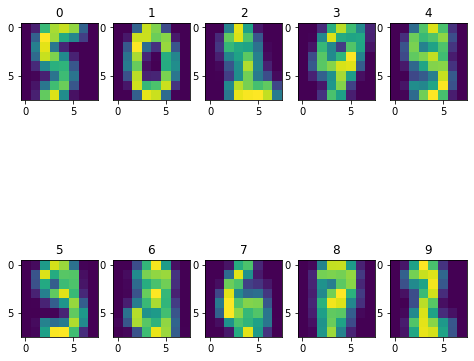

In [223]:
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(nem.mu[i]*16,(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i)
plt.show()
# for i in range(10):
#     img = np.reshape(nem.mu[i],(8,8))
#     imgplot = plt.imshow(img)
#     plt.show()

In [226]:
preds_fix = np.zeros(len(preds))
preds_fix[preds == 0] = 5
preds_fix[preds == 1] = 0
preds_fix[preds == 2] = 1
preds_fix[preds == 3] = 4
preds_fix[preds == 4] = 9
preds_fix[preds == 5] = 3
preds_fix[preds == 6] = 8
preds_fix[preds == 7] = 6
preds_fix[preds == 8] = 7
preds_fix[preds == 9] = 2

In [227]:
print("Confusion matrix own NBGMM:\n%s" % metrics.confusion_matrix(y_train, preds_fix))

Confusion matrix own NBGMM:
[[122   0   0   0   0   0   4   0   0   0]
 [  0  25  43   0   0   2   1  28   6  24]
 [  0  40  80   0   1   0   0   0   9   0]
 [  0   2   3  71   0   0   0  10  13  19]
 [  0   0   0   0  33   0  86   4   5   0]
 [  0   0   0  17   4  80   0   5   0  20]
 [  0  11   0   0   0   0 112   0   1   1]
 [  0   0   0   0  39   0   0  84   1   0]
 [  0   5  10   0   1   0   0  61  16  33]
 [  0   8   0  74  12   1   0  10   3  17]]


In [241]:
print(nem.p_C)
label_dist = [sum(y_train==i)/len(y_train) for i in range(10)]
print(label_dist)

{0: 0.06596219875394893, 1: 0.09662574468890121, 2: 0.0726830447208384, 3: 0.07239844830869152, 4: 0.09069793962723657, 5: 0.12882654440665228, 6: 0.042221295457416236, 7: 0.16209179826394476, 8: 0.1607004078338896, 9: 0.10779257793848009}
[0.10023866348448687, 0.1026252983293556, 0.10342084327764518, 0.09387430389817025, 0.10182975338106603, 0.10023866348448687, 0.09944311853619729, 0.09864757358790771, 0.10023866348448687, 0.09944311853619729]
